In [53]:
#
import numpy as np
import os, sys
import matplotlib.pyplot as plt

sys.path.insert(0, '/global/homes/q/qmxp55/DESI/omarlibs/bgstargets/py')

from io_ import get_sweep_whole, getBGSbits
from io_ import get_random, get_isdesi, get_dict, bgsmask, get_reg, get_svfields
from cuts import getGeoCuts
from QA import getStats, flow

import healpy as hp
import astropy.io.fits as fits
from astropy.coordinates import SkyCoord
import astropy.units as units
import fitsio
from astropy.table import Table

sys.path.append('/global/homes/q/qmxp55/DESI/omarlibs')
import raichoorlib

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## MY BGS cat from DR8

In [2]:
dr8pix     = '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/pixweight/pixweight-dr8-0.31.1.fits'
#Nranfiles = 3
#patch = None #[174., 186., -3., 2.]
#reg = 'south' #'south', 'north', 'decals', 'des', 'svfields'
#dr = 'dr8'
#version = '2.0'
#if dr == 'dr9d': Nranfiles = 20 # because the randoms for dr9d have a density of 100000 = 5000*20

# for healpy
hdr          = fits.getheader(dr8pix,1)
nside,nest   = hdr['hpxnside'],hdr['hpxnest']
npix         = hp.nside2npix(nside)
pixarea      = hp.nside2pixarea(nside,degrees=True)

In [5]:
#dr8 = np.load('/global/cscratch1/sd/qmxp55/sweep_files/dr8_sweep_whole_r21.0_v2.0.npy')
dr8 =  get_sweep_whole(patch=None, dr='dr8', rlimit=21.0, maskbitsource=False, bgsbits=True, opt='1', version='2.0')

sweep file already exist at:/global/cscratch1/sd/qmxp55/sweep_files/dr8_sweep_whole_r21.0_v2.0.npy
Total run time: 0.000221 sec


In [6]:
regdr8 = get_svfields(dr8['RA'],dr8['DEC'])
#regdr8 = get_reg(reg='svfields', hppix=hppix_dr8)
#desidr8 = get_reg(reg='desi', hppix=hppix_dr8)

In [7]:
dr8 = dr8[(regdr8)]

In [8]:
hppix_dr8 = hp.ang2pix(nside,(90.-dr8['DEC'])*np.pi/180.,dr8['RA']*np.pi/180.,nest=True) # catalogue hp pixels array

In [6]:

#hppix_dr8 = hppix_dr8[(regdr8)]

In [9]:
#dr8svf = get_svfields(dr8['RA'],dr8['DEC'])
dr8_n = get_reg(reg='north', hppix=hppix_dr8)
dr8_s = get_reg(reg='south', hppix=hppix_dr8)

In [10]:
dr8n = dr8[(dr8_n) & (dr8['RMAG'] < 20)]
dr8s = dr8[(dr8_s)& (dr8['RMAG'] < 20)]

# DR8 vs DR9d

In [11]:
#dr9d = np.load('/global/cscratch1/sd/qmxp55/sweep_files/dr9d_sweep_whole_r21.0_v2.0.npy')
dr9d = get_sweep_whole(patch=None, dr='dr9d', rlimit=21.0, maskbitsource=False, bgsbits=True, opt='1', version='2.0')

sweep file already exist at:/global/cscratch1/sd/qmxp55/sweep_files/dr9d_sweep_whole_r21.0_v2.0.npy
Total run time: 0.000516 sec


In [12]:
regdr9d = get_svfields(dr9d['RA'],dr9d['DEC'])

In [13]:
dr9d = dr9d[(regdr9d)]

In [14]:
hppix_dr9d = hp.ang2pix(nside,(90.-dr9d['DEC'])*np.pi/180.,dr9d['RA']*np.pi/180.,nest=True) # catalogue hp pixels array

In [12]:
#regdr9d = get_reg(reg='svfields', hppix=hppix_dr9d)
#desidr9d = get_reg(reg='desi', hppix=hppix_dr9d)

In [13]:

#hppix_dr9d = hppix_dr9d[(regdr9d)]

In [15]:
#dr9dsvf = get_svfields(dr9d['RA'],dr9d['DEC'])
dr9d_n = get_reg(reg='north', hppix=hppix_dr9d)
dr9d_s = get_reg(reg='south', hppix=hppix_dr9d)

In [16]:
dr9dn = dr9d[(dr9d_n) & (dr9d['RMAG'] < 20)]
dr9ds = dr9d[(dr9d_s) & (dr9d['RMAG'] < 20)]

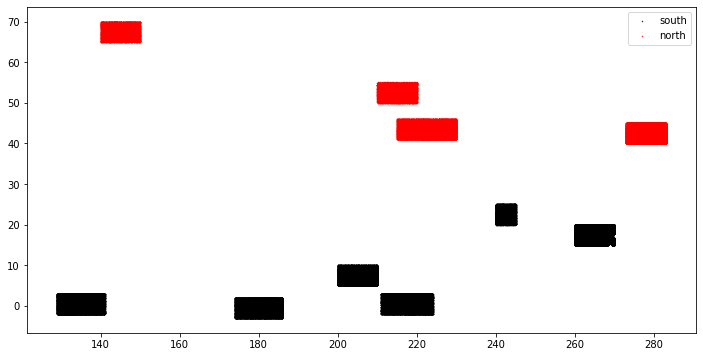

In [17]:
plt.figure(figsize=(12,6))
plt.scatter(dr9ds['RA'][::10], dr9ds['DEC'][::10], s=0.2, c='k', label='south')
plt.scatter(dr9dn['RA'][::10], dr9dn['DEC'][::10], s=0.2, c='r', label='north')
plt.legend()
plt.show()
plt.show()

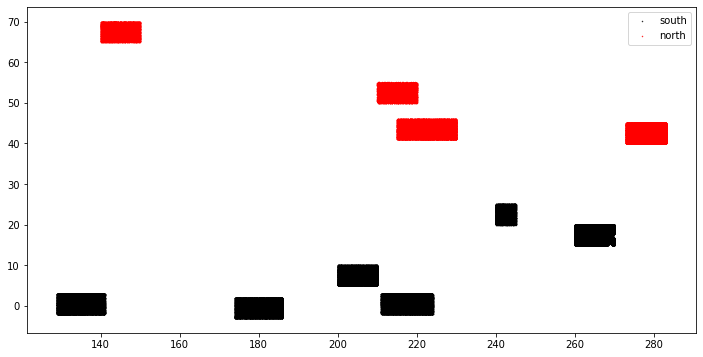

In [18]:
plt.figure(figsize=(12,6))
plt.scatter(dr8s['RA'][::10], dr8s['DEC'][::10], s=0.2, c='k', label='south')
plt.scatter(dr8n['RA'][::10], dr8n['DEC'][::10], s=0.2, c='r', label='north')
plt.legend()
plt.show()

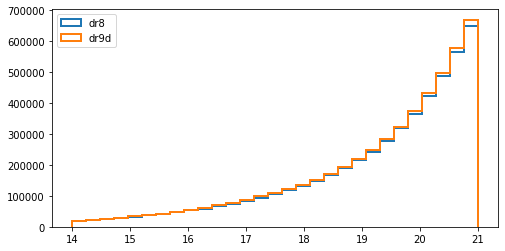

In [20]:
plt.figure(figsize=(8,4))
bins = np.linspace(14, 21, 30)

plt.hist(dr8['RMAG'], bins=bins, histtype='step', lw=2, label='dr8')
plt.hist(dr9d['RMAG'], bins=bins, histtype='step', lw=2, label='dr9d')
plt.legend(loc='upper left')

In [40]:
stars = np.load('/global/cscratch1/sd/qmxp55/pauline/stars_GAIA_TYCHO_13.npy')

In [41]:
regstars = get_svfields(stars['RA'],stars['DEC'])

In [42]:
stars = stars[regstars]

## Some defs...

In [63]:
#
from matplotlib import gridspec
def hexbin(x=None, y=None, clab=None, xlim=None, ylim=None, vmax=None):
    
    #fig,ax = plt.subplots(2,2, figsize=(18,12))
    cols, rows = 1, 1
    fig = plt.figure(figsize=(14*cols,8*rows))
    gs = gridspec.GridSpec(rows,cols,hspace=0.30,wspace=0.1)
    
    if ylim is None: ylim = np.percentile(y[np.isfinite(y)],(0,100))
    if xlim is None: xlim = np.percentile(x[np.isfinite(x)],(0,100))
    mask0 = (y > ylim[0]) & (y < ylim[1]) & (x > xlim[0]) & (x < xlim[1])
    tot = np.sum(mask0)
        
    print('GENERAL: median = %2.3g, mean = %2.3g' %(np.median(y[mask0]), np.mean(y[mask0])))
    
    ax = fig.add_subplot(gs[0])
    pos = ax.hexbin(x[mask0], y[mask0], C=None, gridsize=(80,80), cmap='viridis', bins='log', 
                           mincnt=1, alpha=0.8, vmin=1, vmax=vmax)
    
    plt.axhline(0, ls=':', lw=2, c='k')
    
    if clab is None: clab = r'$N$'
        #if i == 2: fig.colorbar(pos, ax=ax, orientation="horizontal", pad=0.2, label=clab)
        
    #compute median and percentiles
    binx = np.linspace(xlim[0], xlim[1], 30)
    binw = (binx[1] - binx[0])/2
    binc, median, lower, upper = [],[],[],[]
        
    for num in range(len(binx)-1):
        keep = (mask0) & (x > binx[num]) & (x < binx[num+1])
            
        if np.sum(keep) > 0:
            perc = np.percentile(y[keep][np.isfinite(y[keep])],(20,80))
            binc.append(binx[num] + binw)
            median.append(np.median(y[keep]))
            lower.append(perc[0])
            upper.append(perc[1])
        else:
            continue
            
    ax.plot(binc, median, lw=2, c='r')
    ax.fill_between(binc, upper, lower, facecolor='red', alpha=0.3)
    
    ax.set_xlabel(r'rmag DR8', size=15)
    ax.set_ylabel(r'rmag DR8 - rmag DR9d', size=15)
    
    #cbar_ax = fig.add_axes([0.75, 0.12, 0.02, 0.3])
    fig.colorbar(pos)
    #fig.colorbar(pos, cax=cbar_ax)
                


In [91]:
#
def run_compare(dr8=None, dr9d=None, issouth=True):
    
    if issouth:
        Area8 = 302.0
        Area9 = 302.07
        lab = 'SOUTH'
    else:
        Area8 = 139.39
        Area9 = 139.29
        lab = 'NORTH'
        
    den_dr8 = len(dr8)/Area8
    den_dr9d = len(dr9d)/Area9
    print('#dr8 %s: %.2f' %(lab, den_dr8))
    print('#dr9d %s: %.2f' %(lab, den_dr9d))
    print('Diff.: %.2f' %(den_dr9d - den_dr8))
    
    idx2, idx1, d2d, d_ra, d_dec = raichoorlib.match_coord(dr8['RA'], dr8['DEC'], dr9d['RA'], dr9d['DEC'], search_radius=0.5)
    
    dr9dmatch = np.zeros_like(dr9d, dtype=bool)
    dr8match = np.zeros_like(dr8, dtype=bool)
    dr9dmatch[idx1] = True
    dr8match[idx2] = True
    
    print('Targ. Dens. of dr9d not in dr8: %.3f' %(np.sum(~dr9dmatch)/Area9))
    print('Targ. Dens. of dr8 not in dr9d: %.3f' %(np.sum(~dr8match)/Area8))
    
    morphs8 = list(set(dr8['TYPE']))
    morphs9 = list(set(dr9d['TYPE']))
    
    print('========= DR8 %s ========' %(lab))
    for i in morphs8:
        mask = dr8['TYPE'] == i
        densM = np.sum((mask) & (dr8match))/Area8
        densU = np.sum((mask) & (~dr8match))/Area8
        print('%s: \t %.2f (matched) \t %.2f (not-matched)' %(i, densM, densU))
        
    print('========= DR9d %s ========' %(lab))
    for i in morphs9:
        mask = dr9d['TYPE'] == i
        densM = np.sum((mask) & (dr9dmatch))/Area9
        densU = np.sum((mask) & (~dr9dmatch))/Area9
        print('%s: \t %.2f (matched) \t %.2f (not-matched)' %(i, densM, densU))
      
    #------ bgs --------
    bgsb8 = ((dr8['BGSBITS'] & 2**(21)) != 0)
    bgsf8 = ((dr8['BGSBITS'] & 2**(22)) != 0)
    bgs8 = ((dr8['BGSBITS'] & 2**(20)) != 0)
    dr8bgs = dr8[bgs8]
    
    bgsb9 = ((dr9d['BGSBITS'] & 2**(21)) != 0)
    bgsf9 = ((dr9d['BGSBITS'] & 2**(22)) != 0)
    bgs9 = ((dr9d['BGSBITS'] & 2**(20)) != 0)
    dr9dbgs = dr9d[bgs9]
    
    idx2b, idx1b, d2db, d_rab, d_decb = raichoorlib.match_coord(dr8bgs['RA'], dr8bgs['DEC'], dr9dbgs['RA'], dr9dbgs['DEC'], search_radius=0.5)
    
    dr9dbgsmatch = np.zeros_like(dr9dbgs, dtype=bool)
    dr8bgsmatch = np.zeros_like(dr8bgs, dtype=bool)
    dr9dbgsmatch[idx1b] = True
    dr8bgsmatch[idx2b] = True
    
    print('BGS Targ. Dens. of dr9d in dr8: %.3f' %(np.sum(dr9dbgsmatch)/Area9))
    print('BGS Targ. Dens. of dr8 in dr9d: %.3f' %(np.sum(dr8bgsmatch)/Area8))
    print('BGS Targ. Dens. of dr9d not in dr8: %.3f' %(np.sum(~dr9dbgsmatch)/Area9))
    print('BGS Targ. Dens. of dr8 not in dr9d: %.3f' %(np.sum(~dr8bgsmatch)/Area8))
    
    #------------------
    
    match = Table()
    match['RMAG8'] = dr8['RMAG'][idx2]
    match['RMAG9'] = dr9d['RMAG'][idx1]
    
    y = (match['RMAG8'] - match['RMAG9'])
    x = match['RMAG8']
    hexbin(x=x, y=y, clab=None, xlim=None, ylim=[-6, 6], vmax=None)

    if issouth:
        limits = [(211, 224, -2.0, 3.0),
             (200, 210, 5, 10),
             (240, 245, 20, 25)]
    else:
        limits = [(210, 220, 50, 55),
                 (140, 150, 65, 70),
                 (215, 230, 41, 46)]

    fig = plt.figure(figsize=(20, 6*len(limits)))
    
    for num, lim in enumerate(limits):
        for i in [1,2]:
            
            plt.subplot(len(limits), 2, i+num*2)
            if (i == 1): 
                if num == 0: plt.title('DR9d not in DR8', size=18)
                plt.scatter(dr9d['RA'][~dr9dmatch], dr9d['DEC'][~dr9dmatch], c='k', s=1)
            elif (i == 2): 
                if num == 0: plt.title('DR8 not in DR9', size=18)
                plt.scatter(dr8['RA'][~dr8match], dr8['DEC'][~dr8match], c='k', s=1)
            #plt.scatter(dr9ds['RA'][dr9dmatch], dr9ds['DEC'][dr9dmatch], c='gray', alpha=0.1, s=0.01)
            plt.scatter(stars['RA'], stars['DEC'], c='r', s=1)
            plt.xlabel(r'R.A.', size=18)
            plt.ylabel(r'DEC.', size=18)
            plt.xlim(lim[0], lim[1])
            plt.ylim(lim[2], lim[3])
            
    plt.show()
    
    fig = plt.figure(figsize=(20, 6))

    log=True
    bins = np.linspace(13, 21, 30)
    for num, key in enumerate(['RMAG', 'GMAG', 'ZMAG']):

        plt.subplot(1, 3, num+1)
        plt.hist(dr8[key][dr8match], bins=bins, histtype='step', color='k', log=log, label='dr8 matched')
        plt.hist(dr8[key][~dr8match], bins=bins, histtype='step', color='k', log=log, ls='--', label='dr8 not matched')

        plt.hist(dr9d[key][dr9dmatch], bins=bins,  histtype='step', color='r', log=log, label='dr9d matched')
        plt.hist(dr9d[key][~dr9dmatch], bins=bins, histtype='step', color='r', log=log, ls='--', label='dr9d not matched')

        if num == 0: plt.legend(loc='upper left')
        plt.xlabel(key, size=18)
        
    plt.show()


## Matching South

#dr8 SOUTH: 6923.58
#dr9d SOUTH: 6976.95
Diff.: 53.38
Doubly matched objects = 1286
Final matched objects = 2074485
Targ. Dens. of dr9d not in dr8: 109.389
Targ. Dens. of dr8 not in dr9d: 54.421
========= DR8 SOUTH ========
EXP : 	 500.28 (matched) 	 22.39 (not-matched)
DEV : 	 629.18 (matched) 	 9.62 (not-matched)
PSF : 	 5468.18 (matched) 	 13.49 (not-matched)
REX : 	 243.26 (matched) 	 7.40 (not-matched)
COMP: 	 28.26 (matched) 	 1.52 (not-matched)
========= DR9d SOUTH ========
PSF: 	 5465.67 (matched) 	 22.04 (not-matched)
EXP: 	 491.38 (matched) 	 31.51 (not-matched)
DEV: 	 640.43 (matched) 	 24.06 (not-matched)
REX: 	 241.70 (matched) 	 12.31 (not-matched)
SER: 	 28.38 (matched) 	 19.48 (not-matched)
Doubly matched objects = 95
Final matched objects = 413639
BGS Targ. Dens. of dr9d in dr8: 1369.348
BGS Targ. Dens. of dr8 in dr9d: 1369.666
BGS Targ. Dens. of dr9d not in dr8: 50.230
BGS Targ. Dens. of dr8 not in dr9d: 19.086
GENERAL: median = 0.00119, mean = 0.00341


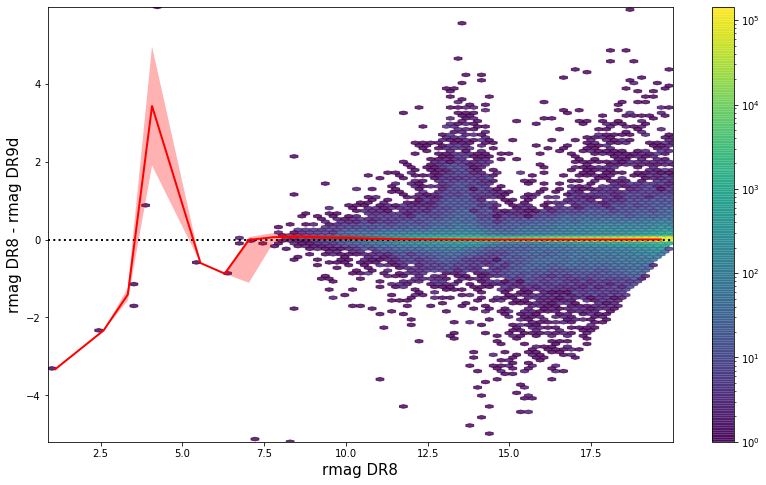

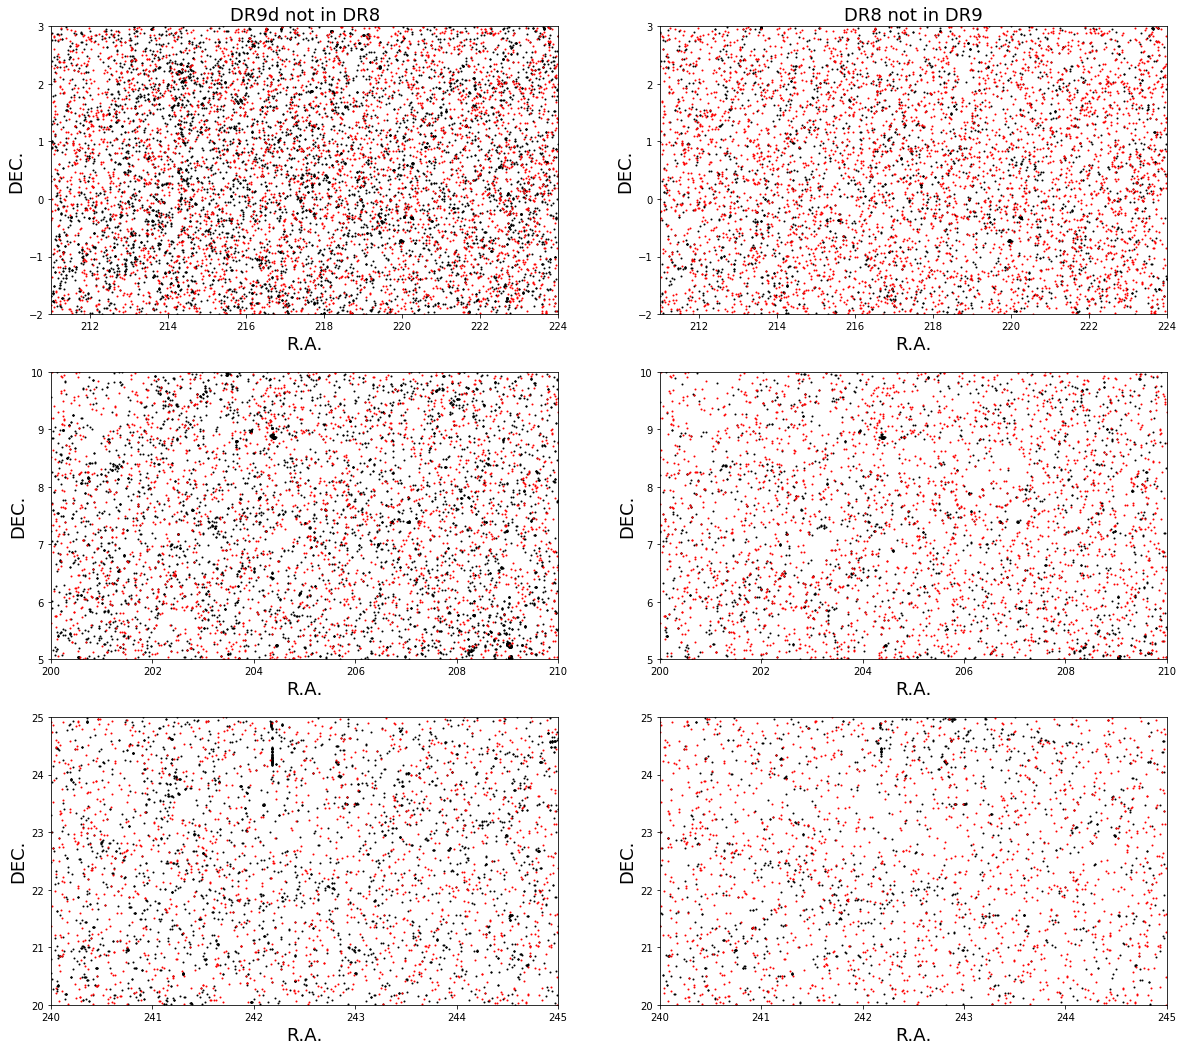

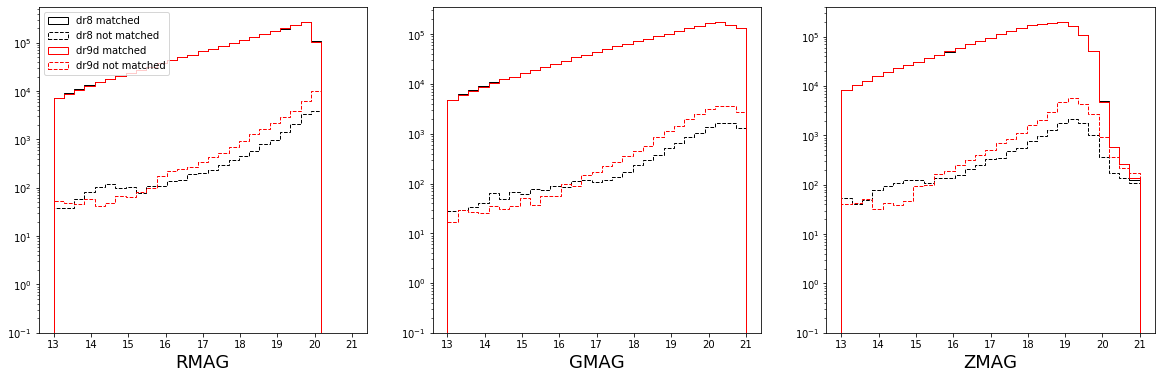

In [92]:
run_compare(dr8=dr8s, dr9d=dr9ds, issouth=True)

## Matching North

#dr8 NORTH: 6454.84
#dr9d NORTH: 6908.20
Diff.: 453.36
Doubly matched objects = 19004
Final matched objects = 878897
Targ. Dens. of dr9d not in dr8: 598.363
Targ. Dens. of dr8 not in dr9d: 149.530
========= DR8 NORTH ========
EXP : 	 432.47 (matched) 	 46.80 (not-matched)
DEV : 	 606.76 (matched) 	 30.98 (not-matched)
PSF : 	 4997.17 (matched) 	 38.97 (not-matched)
REX : 	 246.29 (matched) 	 30.89 (not-matched)
COMP: 	 22.61 (matched) 	 1.89 (not-matched)
========= DR9d NORTH ========
PSF: 	 4999.29 (matched) 	 145.08 (not-matched)
EXP: 	 435.64 (matched) 	 142.67 (not-matched)
DEV: 	 596.57 (matched) 	 32.04 (not-matched)
REX: 	 255.54 (matched) 	 127.86 (not-matched)
SER: 	 22.80 (matched) 	 150.71 (not-matched)
Doubly matched objects = 40
Final matched objects = 175767
BGS Targ. Dens. of dr9d in dr8: 1261.878
BGS Targ. Dens. of dr8 in dr9d: 1260.973
BGS Targ. Dens. of dr9d not in dr8: 38.258
BGS Targ. Dens. of dr8 not in dr9d: 50.585
GENERAL: median = -0.00134, mean = -0.005


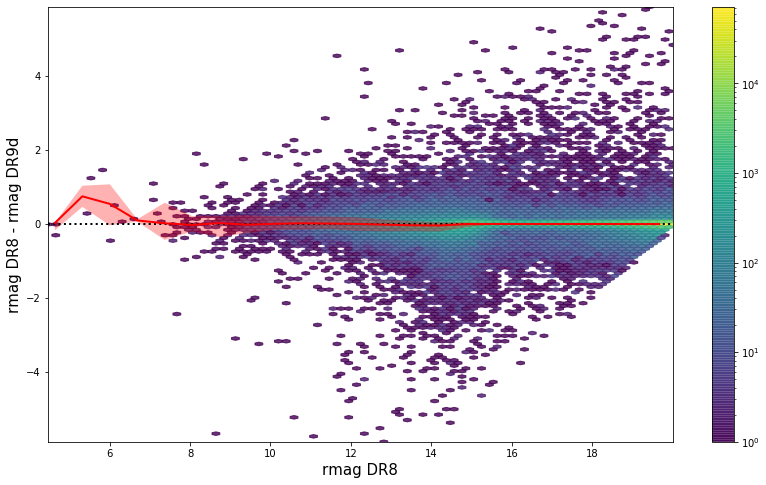

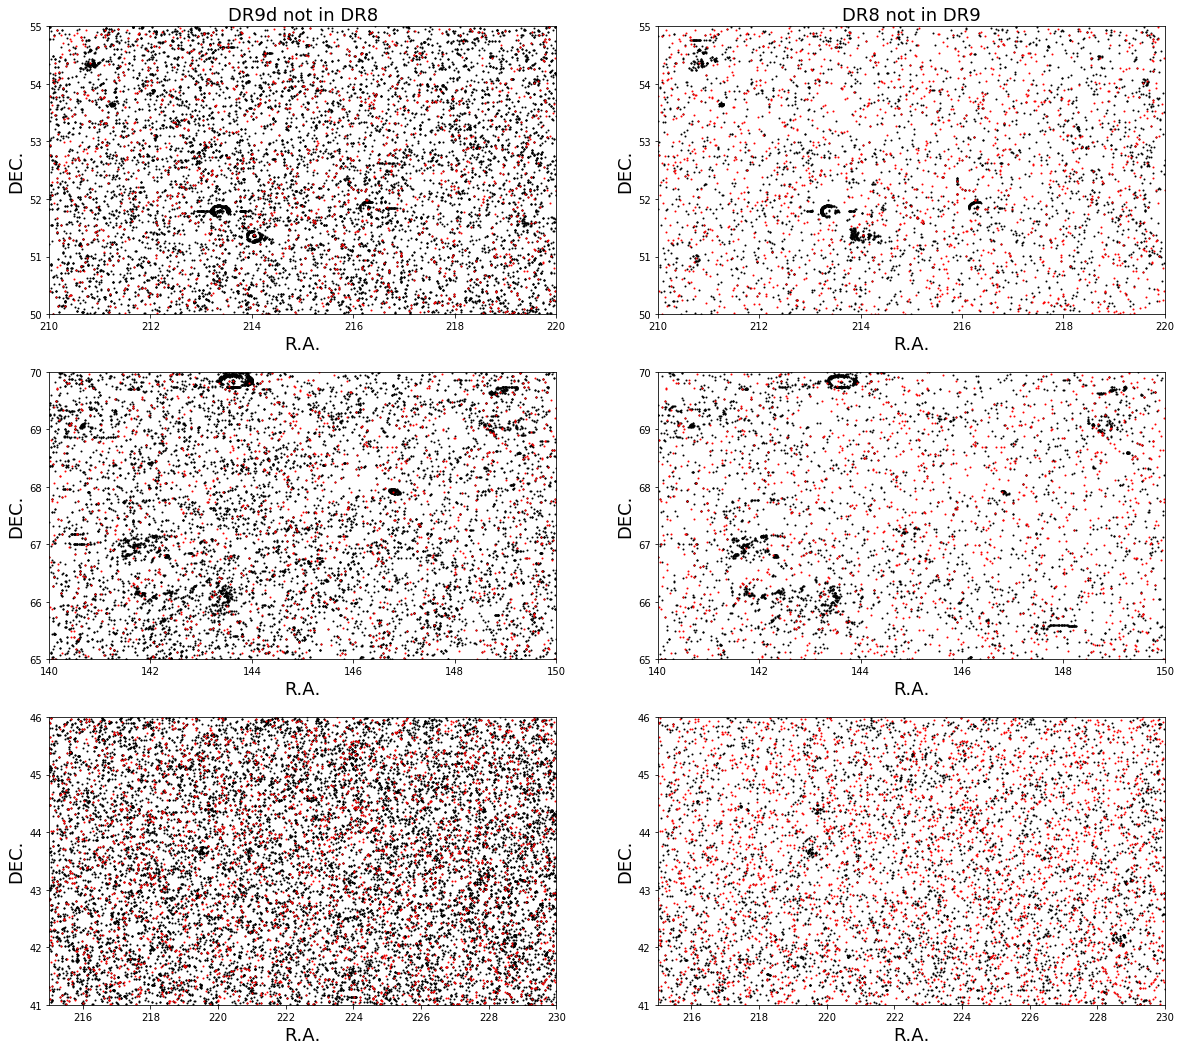

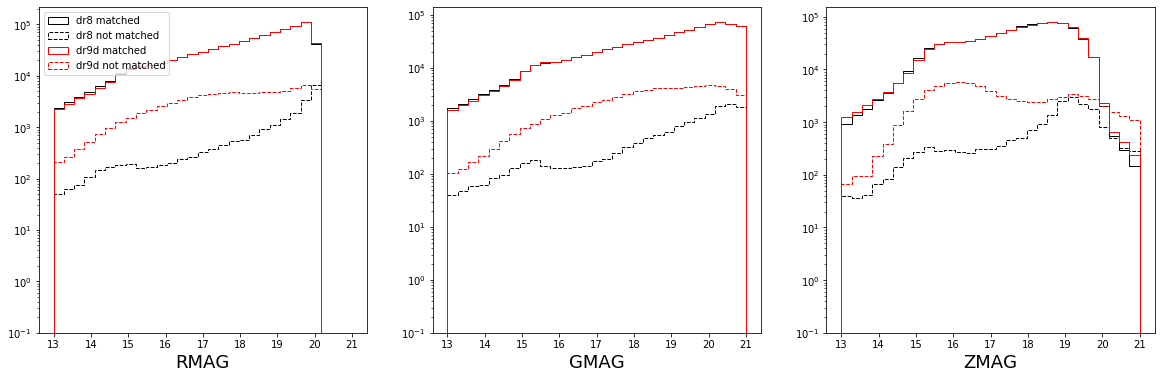

In [93]:
run_compare(dr8=dr8n, dr9d=dr9dn, issouth=False)